In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [2]:
class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

In [3]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )

In [4]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, k_size):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        layers.append(eca_layer(oup, k_size))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [5]:
class ECA_MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super(ECA_MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if c < 96:
                    ksize = 1
                else:
                    ksize = 3
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, k_size=ksize))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = x.mean(-1).mean(-1)
        x = self.classifier(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECA_MobileNetV2().to(device=device)

In [7]:
x = torch.randn(5, 3, 32, 32)
x = x.to(device=device)
y = model(x)
print(y.shape)
print(y)

torch.Size([5, 10])
tensor([[ 4.6944e-02, -2.1138e-01, -1.5371e-01, -3.1771e-01,  2.2915e-01,
          1.3150e-01, -7.7807e-02,  1.2622e-01,  2.7904e-01, -3.6451e-02],
        [-8.9053e-02,  5.5003e-01, -6.6938e-01,  3.0822e-01,  2.2997e-03,
          2.2250e-01,  1.0268e-01,  5.1339e-01, -3.4316e-01,  5.6755e-02],
        [-6.0230e-01, -3.6401e-01, -5.7367e-03, -8.7583e-02, -3.0433e-01,
         -3.6103e-01,  1.2775e-01,  4.7141e-04, -1.2943e-01, -2.7508e-01],
        [-4.7927e-01, -2.8012e-01,  1.2781e-01, -9.5573e-02,  1.3760e-01,
          4.0092e-02,  2.7314e-01,  2.6309e-01,  3.1949e-02, -3.4261e-01],
        [ 3.1020e-01, -2.1480e-01, -6.8241e-02, -1.5429e-01,  1.1539e-01,
          6.3422e-01,  1.6230e-01, -2.6461e-01,  1.6822e-01, -2.5479e-01]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

In [9]:
# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 100

In [10]:
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

dog


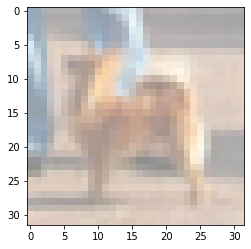

In [14]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Loss: 2.3216168880462646


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Loss: 2.077706813812256


  0%|▏                                                                                 | 2/782 [00:00<01:07, 11.56it/s]

Epoch: 2 Loss: 1.3329700231552124


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Loss: 1.4438362121582031


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Loss: 1.8835519552230835


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Loss: 1.432981252670288


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Loss: 1.1745996475219727


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Loss: 1.4703881740570068


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.8133131265640259


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.939720094203949


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Loss: 1.4068152904510498


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.7378768920898438


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.6376564502716064


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Loss: 1.1439151763916016


  0%|▏                                                                                 | 2/782 [00:00<01:10, 11.05it/s]

Epoch: 14 Loss: 0.7538480758666992


  0%|▏                                                                                 | 2/782 [00:00<01:08, 11.43it/s]

Epoch: 15 Loss: 1.098473072052002


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.6322412490844727


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Loss: 0.723616361618042


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.5310625433921814


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.4576505720615387


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 20 Loss: 1.0948868989944458


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 21 Loss: 1.5443841218948364


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 22 Loss: 1.5797184705734253


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 23 Loss: 0.7420181035995483


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.95it/s]

Epoch: 24 Loss: 0.7272851467132568


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.34it/s]

Epoch: 25 Loss: 0.6940327286720276


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 26 Loss: 1.0407313108444214


  0%|▏                                                                                 | 2/782 [00:00<00:45, 17.24it/s]

Epoch: 27 Loss: 0.8242570757865906


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 28 Loss: 0.6764872670173645


  0%|▏                                                                                 | 2/782 [00:00<00:49, 15.62it/s]

Epoch: 29 Loss: 0.4880322515964508


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.51it/s]

Epoch: 30 Loss: 0.8962132334709167


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.18it/s]

Epoch: 31 Loss: 0.5503997206687927


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 32 Loss: 1.4148766994476318


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 33 Loss: 0.40931057929992676


  0%|▏                                                                                 | 2/782 [00:00<00:47, 16.53it/s]

Epoch: 34 Loss: 1.5282857418060303


  0%|▏                                                                                 | 2/782 [00:00<00:45, 17.09it/s]

Epoch: 35 Loss: 0.5508084893226624


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.66it/s]

Epoch: 36 Loss: 2.024836301803589


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.18it/s]

Epoch: 37 Loss: 0.35464125871658325


  0%|▏                                                                                 | 2/782 [00:00<00:48, 16.00it/s]

Epoch: 38 Loss: 0.5236983299255371


  0%|▏                                                                                 | 2/782 [00:00<00:49, 15.74it/s]

Epoch: 39 Loss: 1.3250833749771118


  0%|▏                                                                                 | 2/782 [00:00<00:47, 16.26it/s]

Epoch: 40 Loss: 1.4489359855651855


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.54it/s]

Epoch: 41 Loss: 1.5230573415756226


  0%|▏                                                                                 | 2/782 [00:00<00:43, 18.01it/s]

Epoch: 42 Loss: 1.0286539793014526


  0%|▏                                                                                 | 2/782 [00:00<00:51, 15.15it/s]

Epoch: 43 Loss: 0.45049452781677246


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 44 Loss: 0.7139728665351868


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 45 Loss: 1.2629183530807495


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 46 Loss: 1.0824956893920898


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 47 Loss: 0.5356349945068359


  0%|▏                                                                                 | 2/782 [00:00<00:45, 17.09it/s]

Epoch: 48 Loss: 0.8592047691345215


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 49 Loss: 0.6480192542076111


  0%|▏                                                                                 | 2/782 [00:00<00:50, 15.38it/s]

Epoch: 50 Loss: 0.6561465859413147


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 51 Loss: 0.7483145594596863


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.51it/s]

Epoch: 52 Loss: 1.140932321548462


  0%|▏                                                                                 | 2/782 [00:00<00:49, 15.62it/s]

Epoch: 53 Loss: 0.24398508667945862


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 54 Loss: 1.6008062362670898


  0%|▏                                                                                 | 2/782 [00:00<00:47, 16.53it/s]

Epoch: 55 Loss: 0.4980733096599579


  0%|▏                                                                                 | 2/782 [00:00<00:40, 19.04it/s]

Epoch: 56 Loss: 0.39265361428260803


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.34it/s]

Epoch: 57 Loss: 0.812653660774231


  0%|▏                                                                                 | 2/782 [00:00<00:45, 17.09it/s]

Epoch: 58 Loss: 0.690904974937439


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 59 Loss: 1.7938802242279053


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.54it/s]

Epoch: 60 Loss: 0.8834801316261292


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.18it/s]

Epoch: 61 Loss: 0.9264689683914185


  0%|▏                                                                                 | 2/782 [00:00<00:47, 16.53it/s]

Epoch: 62 Loss: 0.29162660241127014


  0%|▏                                                                                 | 2/782 [00:00<00:47, 16.39it/s]

Epoch: 63 Loss: 0.7705657482147217


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.69it/s]

Epoch: 64 Loss: 0.6202265024185181


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.66it/s]

Epoch: 65 Loss: 0.5230291485786438


  0%|▏                                                                                 | 2/782 [00:00<00:40, 19.04it/s]

Epoch: 66 Loss: 0.5000953078269958


  0%|▏                                                                                 | 2/782 [00:00<00:52, 14.81it/s]

Epoch: 67 Loss: 1.6045668125152588


  0%|▏                                                                                 | 2/782 [00:00<00:41, 18.69it/s]

Epoch: 68 Loss: 0.030131924897432327


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.18it/s]

Epoch: 69 Loss: 0.4770631790161133


  0%|▏                                                                                 | 2/782 [00:00<00:48, 16.13it/s]

Epoch: 70 Loss: 2.267834424972534


  0%|▏                                                                                 | 2/782 [00:00<00:47, 16.26it/s]

Epoch: 71 Loss: 0.3097670376300812


  0%|▏                                                                                 | 2/782 [00:00<00:45, 17.09it/s]

Epoch: 72 Loss: 0.3503156304359436


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 73 Loss: 0.647020161151886


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.95it/s]

Epoch: 74 Loss: 0.2874040901660919


  0%|▏                                                                                 | 2/782 [00:00<00:50, 15.38it/s]

Epoch: 75 Loss: 1.025239109992981


  0%|▏                                                                                 | 2/782 [00:00<00:41, 18.69it/s]

Epoch: 76 Loss: 0.23734939098358154


  0%|▏                                                                                 | 2/782 [00:00<00:48, 16.13it/s]

Epoch: 77 Loss: 1.280105710029602


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.95it/s]

Epoch: 78 Loss: 0.5330944061279297


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.51it/s]

Epoch: 79 Loss: 0.02433924935758114


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 80 Loss: 0.42053818702697754


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 81 Loss: 0.2787098288536072


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.70it/s]

Epoch: 82 Loss: 1.2738444805145264


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.66it/s]

Epoch: 83 Loss: 0.8809190392494202


  0%|▏                                                                                 | 2/782 [00:00<00:49, 15.87it/s]

Epoch: 84 Loss: 0.5605415105819702


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 85 Loss: 0.06351364403963089


  0%|▏                                                                                 | 2/782 [00:00<00:49, 15.62it/s]

Epoch: 86 Loss: 0.08649414777755737


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 87 Loss: 0.33978182077407837


  0%|▏                                                                                 | 2/782 [00:00<00:43, 17.85it/s]

Epoch: 88 Loss: 2.8906664848327637


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.70it/s]

Epoch: 89 Loss: 1.5053350925445557


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.39it/s]

Epoch: 90 Loss: 0.5408170819282532


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.54it/s]

Epoch: 91 Loss: 0.3129894733428955


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.18it/s]

Epoch: 92 Loss: 0.47473812103271484


  0%|▏                                                                                 | 2/782 [00:00<00:44, 17.54it/s]

Epoch: 93 Loss: 1.2440754175186157


  0%|▏                                                                                 | 2/782 [00:00<00:42, 18.18it/s]

Epoch: 94 Loss: 0.45549166202545166


  0%|▏                                                                                 | 2/782 [00:00<00:41, 18.86it/s]

Epoch: 95 Loss: 1.2449977397918701


  0%|▏                                                                                 | 2/782 [00:00<00:45, 17.24it/s]

Epoch: 96 Loss: 0.5093064904212952


  0%|▏                                                                                 | 2/782 [00:00<00:49, 15.87it/s]

Epoch: 97 Loss: 0.1327536404132843


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.80it/s]

Epoch: 98 Loss: 0.6350622177124023


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:39<00:00, 19.82it/s]

Epoch: 99 Loss: 0.38519638776779175


In [17]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


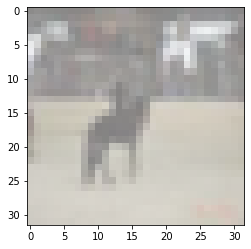

true label: horse
predict label: horse
index number: 1


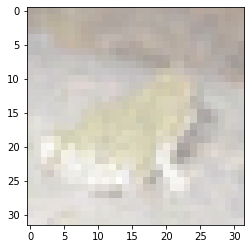

true label: frog
predict label: frog
index number: 2


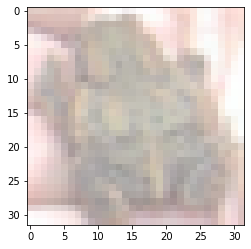

true label: frog
predict label: frog
index number: 3


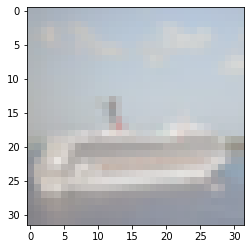

true label: ship
predict label: ship
index number: 4


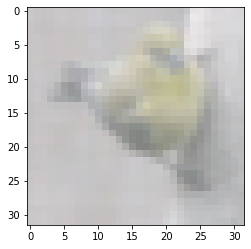

true label: bird
predict label: plane
index number: 5


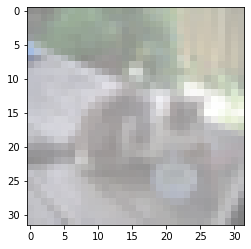

true label: cat
predict label: deer
index number: 6


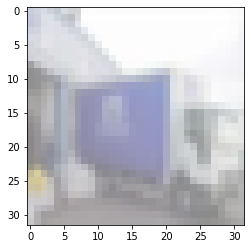

true label: truck
predict label: truck
index number: 7


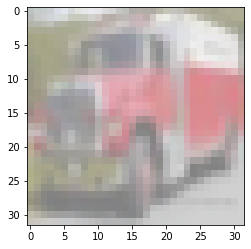

true label: truck
predict label: truck
index number: 8


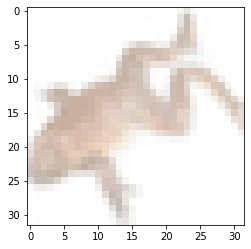

true label: frog
predict label: cat
index number: 9


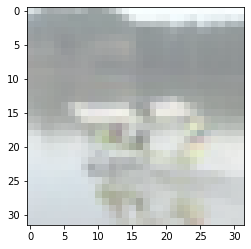

true label: plane
predict label: bird
index number: 10


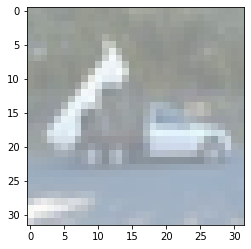

true label: truck
predict label: plane
index number:  


In [18]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction = model(images.to(device=device))
    max_index = np.argmax(prediction[i,:].cpu().detach().numpy())
    print('predict label:',classes[max_index])